In [2]:
import json
import time
import random
import pymongo
import copy
import MyCommon
from pymongo import MongoClient
from collections import deque
import cassiopeia
from cassiopeia import riotapi
import numpy as np
from sklearn import preprocessing, cluster, decomposition
from scipy.cluster.vq import kmeans,vq
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans, AffinityPropagation
from sklearn.decomposition import FastICA, PCA
from sklearn import metrics
import matplotlib.pyplot as plt

riotapi.set_region("KR")
riotapi.set_api_key("79428a9e-5d98-469b-9b9b-429c1a750d24")
riotapi.set_rate_limits((10, 10), (500, 600))
riotapi.print_calls(True)

In [3]:
client = MongoClient()
loladb = client.loladb
summoners_collection = loladb.summoners
matches_collection = loladb.matches
print summoners_collection.count()
print matches_collection.count()

1255
25615


In [4]:
champions = riotapi.get_champions()
dict_id2idx = dict()
dict_idx2id = dict()
dict_id2key = dict()
for a_idx, a_champion in enumerate(champions):
    champ_id = a_champion.id
    champ_key = a_champion.key
    dict_id2idx[champ_id] = a_idx
    dict_idx2id[a_idx] = champ_id
    dict_id2key[champ_id] = champ_key
    
#print dict_id2key[dict_idx2id[132]]
#print dict_id2key

def GetIdxFromId(a_id):
    return dict_id2idx[a_id]

def GetIdFromIdx(a_idx):
    return dict_idx2id[a_idx]

def GetNameFromId(a_id):
    return dict_id2key[a_id]

https://global.api.pvp.net/api/lol/static-data/kr/v1.2/champion?champData=all&api_key=79428a9e-5d98-469b-9b9b-429c1a750d24
https://global.api.pvp.net/api/lol/static-data/kr/v1.2/item?itemListData=all&api_key=79428a9e-5d98-469b-9b9b-429c1a750d24


In [5]:
def PrintMatchWithPair(blue_id, red_id):
    for a_idx, a_match in enumerate(matches_collection.find()):
        winning_side = -1
        if a_match['teams'][0]['winner'] == True and a_match['teams'][1]['winner'] == False:
            winning_side = 0
        if a_match['teams'][0]['winner'] == False and a_match['teams'][1]['winner'] == True:
            winning_side = 1 
        if winning_side == -1:
            return #do not count draw game, if any

        a_duration = a_match['matchDuration']
        a_minute = a_duration/60
        if a_minute <= 20:
            return #do not count surrendered game
        
        participants = a_match['participants']
        blues = [p['championId'] for p in participants[0:5]]
        reds = [p['championId'] for p in participants[5:10]]
        
        if blue_id in blues and red_id in reds:
            print "Match found with id " + a_match['matchId']
    

In [7]:
CHAMP_NUM = len(champions)
against_win_mat = np.zeros((CHAMP_NUM, CHAMP_NUM))
against_sum_mat = np.zeros((CHAMP_NUM, CHAMP_NUM))
synergy_win_mat = np.zeros((CHAMP_NUM, CHAMP_NUM))
synergy_sum_mat = np.zeros((CHAMP_NUM, CHAMP_NUM))
against_matrix = np.zeros((CHAMP_NUM, CHAMP_NUM))
synergy_matrix = np.zeros((CHAMP_NUM, CHAMP_NUM))

def SetWinningAgainst(a_blue_idx, a_red_idx, isWinning):
    #think the map is symmetric
    blue_idx = a_blue_idx
    red_idx = a_red_idx
    if a_blue_idx > a_red_idx:
        blue_idx = a_red_idx
        red_idx = a_blue_idx
    against_sum_mat[blue_idx, red_idx] += 1
    if isWinning:
        against_win_mat[blue_idx, red_idx] += 1
        
def SetWinningWith(a_idx, b_idx, isWinning):
    small_idx = a_idx
    large_idx = b_idx
    if a_idx > b_idx:
        small_idx = b_idx
        large_idx = a_idx
        
    synergy_sum_mat[small_idx, large_idx] += 1
    if isWinning:
        synergy_win_mat[small_idx, large_idx] += 1

def FillAgainstMatrix(blue_participants, red_participants, winning_side):
    for a_blue in blue_participants:
        blue_id = a_blue['championId']
        blue_idx = GetIdxFromId(blue_id)
        for a_red in red_participants:
            red_id = a_red['championId']
            red_idx = GetIdxFromId(red_id)
            isWinning = winning_side == 0
            SetWinningAgainst(blue_idx, red_idx, isWinning)
    
def FillSynergyMatrix(participants, isWinner):
    for a_participant in participants:
        champ_id = a_participant['championId']
        champ_idx = GetIdxFromId(champ_id)
        for another_part in participants:
            another_id = another_part['championId']
            another_idx = GetIdxFromId(another_id)
            if champ_id != another_id:
                SetWinningWith(champ_idx, another_idx, isWinner)

def FillMatrixFromMatch(a_match):
    #0 if blue win, 1 if red win
    winning_side = -1
    if a_match['teams'][0]['winner'] == True and a_match['teams'][1]['winner'] == False:
        winning_side = 0
    if a_match['teams'][0]['winner'] == False and a_match['teams'][1]['winner'] == True:
        winning_side = 1 
    if winning_side == -1:
        return #do not count draw game, if any
    
    a_duration = a_match['matchDuration']
    a_minute = a_duration/60
    if a_minute <= 20:
        return #do not count surrendered game
    
    participants = a_match['participants']
    
    has164 = False  
    for a_participant in participants:    
        if a_participant['championId'] == 164:
            has164 = True
    if has164:
        return    

    FillAgainstMatrix(participants[0:5], participants[5:10], winning_side)
    FillSynergyMatrix(participants[0:5], winning_side == 0)
    FillSynergyMatrix(participants[5:10], winning_side == 1)
    
    global mat_count
    mat_count += 1

MAT_NUM = 10000
mat_count = 0
mat_end = 0

for a_idx, a_match in enumerate(matches_collection.find()):
    FillMatrixFromMatch(a_match)
    
    if mat_count == MAT_NUM:
        mat_end = a_idx
        break
        
    if a_idx % 500 == 0:
        print a_idx

0
500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000
7500
8000
8500
9000
9500
10000
10500
11000
11500
12000
12500
13000


In [8]:
against_sum_mat_fill = against_sum_mat.copy()
synergy_sum_mat_fill = synergy_sum_mat.copy()
against_sum_mat_fill[against_sum_mat_fill == 0] = 1
synergy_sum_mat_fill[synergy_sum_mat_fill == 0] = 1
against_matrix = against_win_mat / against_sum_mat_fill
synergy_matrix = synergy_win_mat / synergy_sum_mat_fill

In [10]:
print against_matrix[0, :]
print against_sum_mat[0, :]

[ 0.          0.5         0.          0.          0.          0.25        0.5
  1.          0.          0.          0.          0.          0.          0.
  0.5         0.          0.          0.          1.          0.8         0.
  1.          0.75        0.          0.625       0.33333333  0.2
  0.71428571  0.5         0.          0.          0.          0.
  0.66666667  0.5         0.          1.          0.5         0.          1.
  0.55555556  0.          0.75        0.75        0.6875      0.          0.625
  0.75        0.33333333  0.          0.75        0.          0.875       1.
  0.          0.          0.25        0.          0.5         1.          1.
  0.          1.          0.          0.33333333  0.          0.66666667
  0.5         0.5         0.          0.          0.5         0.          0.
  0.6         0.          0.          0.33333333  0.          0.5         0.
  0.          0.          0.          0.          0.          0.          0.4
  0.33333333  0.     

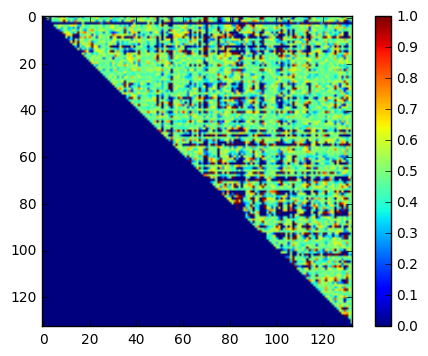

In [9]:
plt.imshow(against_matrix)
plt.colorbar(orientation='vertical')
plt.show()

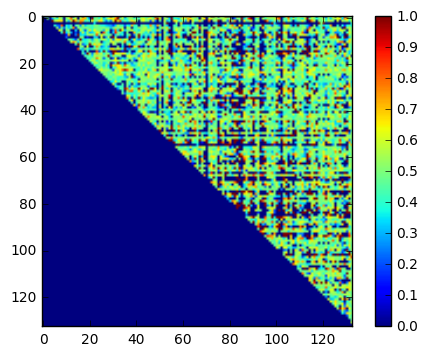

In [10]:
plt.imshow(synergy_matrix)
plt.colorbar(orientation='vertical')
plt.show()

In [14]:
#print some highest / lowest samples in against matrix
MINIMAL_NUM = 20
THRESH_VAL = 0.25
print 133 * 132
print sum(sum(against_sum_mat > MINIMAL_NUM))
against_matrix_copy = against_matrix.copy()
against_matrix_copy[against_sum_mat < MINIMAL_NUM] = 0

synergy_matrix_copy = synergy_matrix.copy()
synergy_matrix_copy[synergy_sum_mat < MINIMAL_NUM] = 0

print sum(sum(against_matrix_copy > (1 - THRESH_VAL)))
print sum(sum(np.logical_and(against_matrix_copy > 0, against_matrix_copy < THRESH_VAL)))

def PrintHighestPair(matrix_copy, high_thresh, sum_mat, content):
    highest_list = matrix_copy > high_thresh
    (highestX, highestY) = np.where(highest_list == True)
    
    for i in range(len(highestX)):
        print str(highestX[i]) + "-" + str(highestY[i])
        blue_champ = GetNameFromId(GetIdFromIdx(highestX[i]))
        red_champ = GetNameFromId(GetIdFromIdx(highestY[i]))
        print "%s: %s to %s with winrate %f in %d games" % (content, blue_champ, red_champ, 
                                                        matrix_copy[highestX[i], highestY[i]],
                                                       sum_mat[highestX[i], highestY[i]])
        
        if content == "Against":
            print "%s: %s to %s with winrate %f in %d games" % (content, red_champ, blue_champ, 
                                                            matrix_copy[highestY[i], highestX[i]],
                                                           sum_mat[highestY[i], highestX[i]])
PrintHighestPair(against_matrix_copy, (1 - THRESH_VAL), against_sum_mat, "Against")
PrintHighestPair(synergy_matrix_copy, (1 - THRESH_VAL), synergy_sum_mat, "Synergy")

def PrintLowestPair(matrix_copy, low_thresh, sum_mat, content):
    lower_list = np.logical_and(matrix_copy > 0, matrix_copy < low_thresh)
    (lX, lY) = np.where(lower_list == True)
    for i in range(len(lX)):
        blue_champ = GetNameFromId(GetIdFromIdx(lX[i]))
        red_champ = GetNameFromId(GetIdFromIdx(lY[i]))
        print "%s: %s to %s with winrate %f in %d games" % (content, blue_champ, red_champ, 
                                                        matrix_copy[lX[i], lY[i]],
                                                       sum_mat[lX[i], lY[i]])
        if content == "Against":
            print "%s: %s to %s with winrate %f in %d games" % (content, red_champ, blue_champ, 
                                                            matrix_copy[lY[i], lX[i]],
                                                           sum_mat[lY[i], lX[i]])

#print some highest / lowest samples in synergy matrix
    
PrintLowestPair(against_matrix_copy, THRESH_VAL, against_sum_mat, "Against")
PrintLowestPair(synergy_matrix_copy, THRESH_VAL, synergy_sum_mat, "Synergy")

17556
3620
3
6
19-41
Against: Orianna to Kindred with winrate 0.821429 in 28 games
Against: Kindred to Orianna with winrate 0.000000 in 0 games
31-33
Against: Shyvana to Fiora with winrate 0.777778 in 27 games
Against: Fiora to Shyvana with winrate 0.000000 in 0 games
79-108
Against: Rumble to AurelionSol with winrate 0.809524 in 21 games
Against: AurelionSol to Rumble with winrate 0.000000 in 0 games
1-31
Synergy: Jax to Shyvana with winrate 0.761905 in 42 games
1-88
Synergy: Jax to Velkoz with winrate 0.857143 in 42 games
2-33
Synergy: Shaco to Fiora with winrate 0.842105 in 38 games
2-71
Synergy: Shaco to Morgana with winrate 0.785714 in 28 games
6-31
Synergy: Kled to Shyvana with winrate 0.789474 in 38 games
7-26
Synergy: Brand to Trundle with winrate 0.833333 in 24 games
7-111
Synergy: Brand to Malzahar with winrate 0.785714 in 28 games
8-23
Synergy: Rammus to Karthus with winrate 0.833333 in 24 games
11-127
Synergy: Braum to Vi with winrate 0.769231 in 26 games
16-104
Synergy: Xe

In [112]:
print against_matrix_copy[122, 108]
print against_sum_mat[108, 122]
print against_matrix_copy[108, 122]

0.74
49.0
0.0


In [104]:
#Check blue Twitch to red Jayce bug?
def CheckChampID():
    for each_id in dict_id2key:
        if dict_id2key[each_id] == "Jayce":
            print "Id for Jayce"
            print each_id
        if dict_id2key[each_id] == "Twitch":
            print "Id for Twitch"
            print each_id
twitch_id = 29
jayce_id = 126

def CheckTwitchToJayce():
    for a_idx, a_match in enumerate(matches_collection.find()):
        participants = a_match['participants']
        blues = [p['championId'] for p in participants[0:5]]
        reds = [p['championId'] for p in participants[5:10]]
        
        if twitch_id in blues and jayce_id in reds:
            print str(a_match['teams'][0]['winner']) + "-" + str(a_match['teams'][1]['winner'])
    
#CheckTwitchToJayce()
twitch_idx = GetIdxFromId(twitch_id)
jayce_idx = GetIdxFromId(jayce_id)
print against_win_mat[twitch_idx, jayce_idx]
print against_sum_mat[twitch_idx, jayce_idx]

22.0
46.0
